# <a href="http://www.redditscore.com">![redditscore](https://s3.us-east-2.amazonaws.com/redditscore/logo.png)</a> 
***A machine learning approach to predicting how badly you'll get roasted for your sub-par reddit comments.***

Alex Hartford & Trevor Hacker

### **Dataset**

Reddit comments from September, 2018 (<a href="http://files.pushshift.io/reddit/">source</a>).  This is well over 100gb of data.  We will likely only use a subset of the data but will ultimately try to use the entire dataset.

### **Objectives**

Create a linear regression model to predict the reddit score of a comment a user is considering posting. 

Stretch goal - narrow comment scoring down by subreddit, as comment popularity will differ between reddit communities.

Allow users to use this model with a publicly available <a href="http://www.redditscore.com/api">API</a> & <a href="http://www.redditscore.com">Website</a>.

Open source the project to allow further contributions if anyone is interested.

In [261]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import imblearn

from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.decomposition import PCA

print('Libraries loaded!')

Libraries loaded!


## Import and Clean Data

In [262]:
print('Loading memes...')

# df = pd.read_json('https://s3.us-east-2.amazonaws.com/redditscore/25rows', lines=True)
df = pd.read_csv('https://s3.us-east-2.amazonaws.com/redditscore/2500rows.csv')
#df = pd.read_csv('https://s3.us-east-2.amazonaws.com/redditscore/2mrows.csv', error_bad_lines=False, engine='python')
print('Memes are fully operational!')

Loading memes...
Memes are fully operational!


In [263]:
print(df.dtypes)
print()
print(df.shape)
df.head(10)

subreddit     object
body          object
score        float64
dtype: object

(2487, 3)


,subreddit,body,score
0,LabVIEW,Seconding this Ive used it on some pretty larg...,1.0
1,Bitcoin,I am not in debt and I shall rise again to inv...,0.0
2,worldnews,So that thin crowd was actually Russians? I wa...,7.0
3,AteTheOnion,[deleted],8.0
4,youseeingthisshit,I hope he ran away like a giggling school girl...,5.0
5,anime_irl,You can just tell that he's trying not to say ...,1.0
6,NintendoSwitch,Get Zelda,86.0
7,AskEconomics,[removed],2.0
8,mexico,[removed],1.0
9,nottheonion,Nobody likes a lingerer,2.0


The score will always be an integer since it is based on upvotes and downvotes. Before converting however, we need to check if there are any null values.

In [264]:
df.isna().sum()

subreddit     0
body          5
score        21
dtype: int64

In [265]:
df[df.isnull().any(axis=1)].head(20)

,subreddit,body,score
243,AskRedditUL,/u/lifeandtimes89,NaN
244,Your post,NaN,NaN
245,&gt;Redditors I want to here your hero storie...,NaN,NaN
246,was mentioned since it was deleted by the res...,NaN,NaN
247,If you would like to submit your question aga...,NaN,NaN
248,Feel free to submit your question here on /r/...,NaN,NaN
249,**Subscribe to this subreddit for more unrest...,1,NaN
809,TrumpPA,I've taken the liberty of creating an archive ...,NaN
810,(If you would like to support Philly.com fina...,2,NaN
833,lego_raffles,Raffle [Announcement](/r/lego_raffles/comments...,NaN


There is only a small amount of null values and they appear to be of little use, so removing them seems to be the best bet. Once the null values are removed we can convert score to an integer.

In [266]:
df = df.dropna()
df['score'] = df['score'].astype('int')

In [267]:
print(df.shape)
df.head(10)

(2466, 3)


,subreddit,body,score
0,LabVIEW,Seconding this Ive used it on some pretty larg...,1
1,Bitcoin,I am not in debt and I shall rise again to inv...,0
2,worldnews,So that thin crowd was actually Russians? I wa...,7
3,AteTheOnion,[deleted],8
4,youseeingthisshit,I hope he ran away like a giggling school girl...,5
5,anime_irl,You can just tell that he's trying not to say ...,1
6,NintendoSwitch,Get Zelda,86
7,AskEconomics,[removed],2
8,mexico,[removed],1
9,nottheonion,Nobody likes a lingerer,2


## Initial Data Analysis

Before getting into handling the comment body a better understanding of the score collumn needs to be gained.

In [268]:
df['score'].describe()

count    2466.000000
mean        9.634631
std       171.808223
min       -27.000000
25%         1.000000
50%         2.000000
75%         4.000000
max      8450.000000
Name: score, dtype: float64

c:\users\hackert\appdata\local\continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


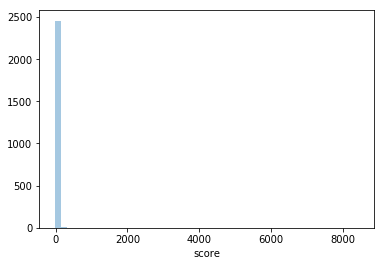

In [269]:
sns.distplot(df["score"], kde=False)

As seen standard deviation and the distribution plot, there is a large distribution of data which makes the dataset skewed.

In order to solve this log sclaling can be applied which might be useful later on.

c:\users\hackert\appdata\local\continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


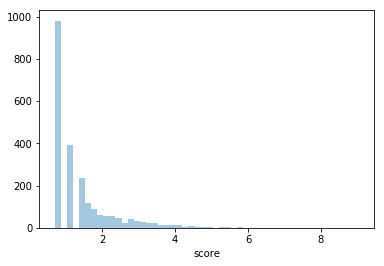

In [270]:
mask = df["score"] > 0
sns.distplot(np.log1p(df["score"][mask]), kde=False)

The positive scores appear to be skewed with a significant majority of values being equal to 1. 

c:\users\hackert\appdata\local\continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


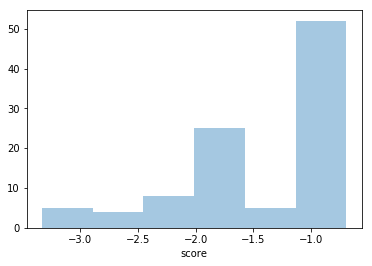

In [271]:
mask = df["score"] < 0
sns.distplot(-np.log1p(-df["score"][mask]), kde=False)

The negative scores also seem a little skewed.

#### Adding another score column

In order to understand the data better and also create a logistic regression model a seperate column was created with the values of positive, negative or one score. Positive score being anything greater than 1, negative being anything less than 1 and one being 1. The reason for this classification is how comments on reddit work, since whenever a comment is made it automatically gets an upvote and therfore if the score is zero it got a downvote.

In [272]:
df['pn_score'] = ""

for i in df['score'].index:
    if  df['score'].at[i] > 1:
        df['pn_score'].at[i] = 'positive'
    elif float(df['score'].at[i]) <= 0:
        df['pn_score'].at[i] = 'negative'
    else:
        df['pn_score'].at[i] = 'one'  

df.head(10)

,subreddit,body,score,pn_score
0,LabVIEW,Seconding this Ive used it on some pretty larg...,1,one
1,Bitcoin,I am not in debt and I shall rise again to inv...,0,negative
2,worldnews,So that thin crowd was actually Russians? I wa...,7,positive
3,AteTheOnion,[deleted],8,positive
4,youseeingthisshit,I hope he ran away like a giggling school girl...,5,positive
5,anime_irl,You can just tell that he's trying not to say ...,1,one
6,NintendoSwitch,Get Zelda,86,positive
7,AskEconomics,[removed],2,positive
8,mexico,[removed],1,one
9,nottheonion,Nobody likes a lingerer,2,positive


positive    1303
one          981
negative     182
Name: pn_score, dtype: int64


Text(0,0.5,'Number of Samples')

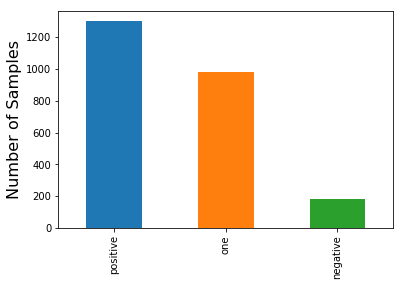

In [273]:
pn_counts = df['pn_score'].value_counts()
print(pn_counts)
pn_counts.plot.bar()
plt.ylabel("Number of Samples", fontsize=16)

Again there is an issue with distribution here. The majority of dataset has positive score values, where negative scores are much less frequent.

## Logistic Regression Model
There will be a combination of logistic regression and linear regression models used.

The logistic model will be created based on the categorical score values, so it will predict whether the comment will have a postive or negative score or a score of 1.  

Since the data is so skewed a simple random over-sampling was used in order to increase the number of negative scores. The reason for using over-sampling as opposed to under-sampling is because we didn't want to loose any comments that could contribute as predictors. This does run the risk of overfitting the data however.

Random over-sampling:
positive    1303
negative     981
one          981
Name: pn_score, dtype: int64


Text(0,0.5,'Number of Samples')

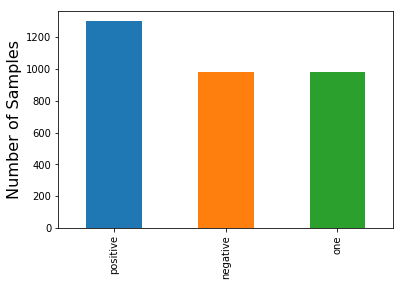

In [274]:
count_pos, count_one, count_neg = df['pn_score'].value_counts()

df_pos_score = df[df['pn_score'] == 'positive']
df_neg_score = df[df['pn_score'] == 'negative']
df_one_score = df[df['pn_score'] == 'one']

df_neg_score_over = df_neg_score.sample(count_one, replace=True)
df_score_over = pd.concat([df_pos_score, df_neg_score_over, df_one_score], axis=0)

print('Random over-sampling:')

pn_counts = df_score_over['pn_score'].value_counts()
print(pn_counts)
pn_counts.plot.bar()
plt.ylabel("Number of Samples", fontsize=16)

In order for the comments to be meaningful predictors of score they first need to be turned into a vector of numerical features. The vectorizer used implements Text Frequency-Inverse Document Frequency (TfIdf) weighting. Additionally stop_words were removed from the vector.

In [275]:
log_vect = TfidfVectorizer(max_df = 0.95, min_df = 5, binary=True, stop_words='english')
text_features = log_vect.fit_transform(df_score_over.body)
print(text_features.shape)

(3265, 1622)


In [276]:
list(log_vect.vocabulary_)[:10]

['actually',
 'joke',
 'turns',
 'deleted',
 'hope',
 'away',
 'like',
 'school',
 'girl',
 'mind']

Now that the comments are turned into vectorized features they can be used in the logistic regression model. In order to achieve better results the random over-sampled data is used.

In [277]:
encoder = LabelEncoder()
numerical_labels = encoder.fit_transform(df_score_over['pn_score'])

training_X, testing_X, training_y, testing_y = train_test_split(text_features,
                                                               numerical_labels,
                                                               stratify=numerical_labels)
print(training_y)

logistic_regression = SGDClassifier(loss="log", penalty="l2", max_iter=1500)
logistic_regression.fit(training_X, training_y)
pred_labels = logistic_regression.predict(testing_X)

accuracy = accuracy_score(testing_y, pred_labels)
cm = confusion_matrix(testing_y, pred_labels)

print("Accuracy:", accuracy)
print("Classes:", str(encoder.classes_))
print("Confusion Matrix:")
print(cm)

[1 2 0 ... 0 0 2]
Accuracy: 0.6242350061199511
Classes: ['negative' 'one' 'positive']
Confusion Matrix:
[[224  10  12]
 [ 25  77 143]
 [ 23  94 209]]


According to the confusion matrix the model struggles with determining a comment that has a score of 1 and usually mistakes it for a positive comment. It seems to perform the best with negative comments which could indicate overfitting of the data.

## Linear Regression Models

There will be two linear regression models, one for detecting the value of the positive score comments and another for detective the value of the negative score comments. The specific one will be used depending on the outcome of the logistic regression model.

### Positive Scores

The first linear regression model will predict that of the postive score. In order to do that only the rows with a positive score are necessary.

In [278]:
pos_score_df = df[df.pn_score == 'positive']

pos_score_df.head()

,subreddit,body,score,pn_score
2,worldnews,So that thin crowd was actually Russians? I wa...,7,positive
3,AteTheOnion,[deleted],8,positive
4,youseeingthisshit,I hope he ran away like a giggling school girl...,5,positive
6,NintendoSwitch,Get Zelda,86,positive
7,AskEconomics,[removed],2,positive


Similarily to the logistic regression the comments need to be transformed into a vector of numerical values.

In [279]:
pos_vect = TfidfVectorizer(max_df = 0.95, min_df = 5, binary=True, stop_words='english')
text_features = pos_vect.fit_transform(pos_score_df.body)
print(text_features.shape)

(1303, 573)


In [280]:
list(pos_vect.vocabulary_)[:10]

['actually',
 'turns',
 'deleted',
 'hope',
 'away',
 'like',
 'school',
 'mind',
 'removed',
 'dude']

Now that the comments are vectorized, the model can be created. In order to eliminate the issue with large distribution noticed during the alaysis, the scores are log scaled.

In [281]:
X_train, X_test, y_train, y_test = train_test_split(text_features, np.log1p(pos_score_df['score']))

pos_linear_regression = SGDRegressor(max_iter=1500)
pos_linear_regression.fit(X_train, y_train)
test = pos_linear_regression.predict(X_test)
mse = mean_squared_error(y_test, test)
rmse = np.sqrt(mse)
print()
print("Positive Score Model MSE:", mse)
print("Positive Score Model RMSE:", rmse)


Positive Score Model MSE: 0.9211654046949048
Positive Score Model RMSE: 0.9597736215873537


Based on the rmse the model seems to preform pretty well.

### Negative Scores

The second linear regression model will predict the negative scores. Similarily to the first model only the rows with negative scores are necessary and the comment need to be vectorized using those.

In [282]:
neg_score_df = df[df.pn_score == 'negative']

neg_score_df.head()

,subreddit,body,score,pn_score
1,Bitcoin,I am not in debt and I shall rise again to inv...,0,negative
14,ireland,"Interesting but ""re-legalised"" is the wrong te...",0,negative
15,nfl,Defense won't win you championships anymore. I...,-8,negative
27,CFB,You must have X-ray vision to be able to see t...,0,negative
30,IdiotsInCars,I came here to say this! Regardless of opinion...,-18,negative


In [283]:
neg_vect = TfidfVectorizer(max_df = 0.95, min_df = 5, binary=True, stop_words='english')
text_features = neg_vect.fit_transform(neg_score_df.body)
print(text_features.shape)

(182, 33)


In [284]:
list(neg_vect.vocabulary_)[:10]

['trump',
 'going',
 'say',
 'right',
 'deleted',
 'removed',
 'people',
 've',
 'saying',
 'game']

In [285]:
X_train, X_test, y_train, y_test = train_test_split(text_features, -np.log1p(-neg_score_df["score"]))

neg_linear_regression = SGDRegressor(max_iter=1500)
neg_linear_regression.fit(X_train, y_train)
test = neg_linear_regression.predict(X_test)
mse = mean_squared_error(y_test, test)
rmse = np.sqrt(mse)
print()
print("Negative Score Model MSE:", mse)
print("Negative Score Model RMSE:", rmse)


Negative Score Model MSE: 1.306159039102519
Negative Score Model RMSE: 1.1428731509238106


The results are similar to the first model.

## Combining Models

First the logistic regression model will be used to preditc whether or not the score is negative or positive, then depending on the outcome the appropriate linear regression model will be used to predict the score value

In [286]:
a = (["You sir a simple idiot. Or a Russian bot. Either way not worth an actual sentence on why I didn't vote for that loon."])

logistic_result = logistic_regression.predict(log_vect.transform(a))
print('Logistic Result: ')
print(logistic_result)
print()

if(logistic_result) == 2:
    linear_result = pos_linear_regression.predict(pos_vect.transform(a))
    print('Linear Result: ')
    print(linear_result)
elif(logistic_result) == 0:
    linear_result = neg_linear_regression.predict(neg_vect.transform(a))
    print('Linear Result: ')
    print(linear_result)

Logistic Result: 
[0]

Linear Result: 
[-0.98265367]
